Generated 30 random jobs for GA training:
  Job 1: arrival=5.10, processing=0.25, type=Type Y, priority=1
  Job 2: arrival=6.36, processing=13.34, type=Type Z, priority=3
  Job 3: arrival=17.50, processing=0.91, type=Type Y, priority=1
  Job 4: arrival=17.65, processing=2.47, type=Type Z, priority=3
  Job 5: arrival=17.79, processing=2.22, type=Type Z, priority=3
  ...
Starting Genetic Algorithm Optimization with Random Jobs
Generation 0:
  Best cost: 33.10 (weight: 0.15)
  Best queue length: 1.97 (weight: 0.85)
  Best fitness: -0.3878, Average fitness: -17.1917
  Normalization range - Cost: [0.52, 60.54], Queue: [1.37, 23.88]
Generation 1:
  Best cost: 24.41 (weight: 0.44)
  Best queue length: 1.95 (weight: 0.56)
  Best fitness: -0.9048, Average fitness: -8.6803
  Normalization range - Cost: [0.52, 60.54], Queue: [1.36, 23.89]
Generation 2:
  Best cost: 25.53 (weight: 0.62)
  Best queue length: 1.94 (weight: 0.38)
  Best fitness: -0.4000, Average fitness: -1.1382
  Normalization range

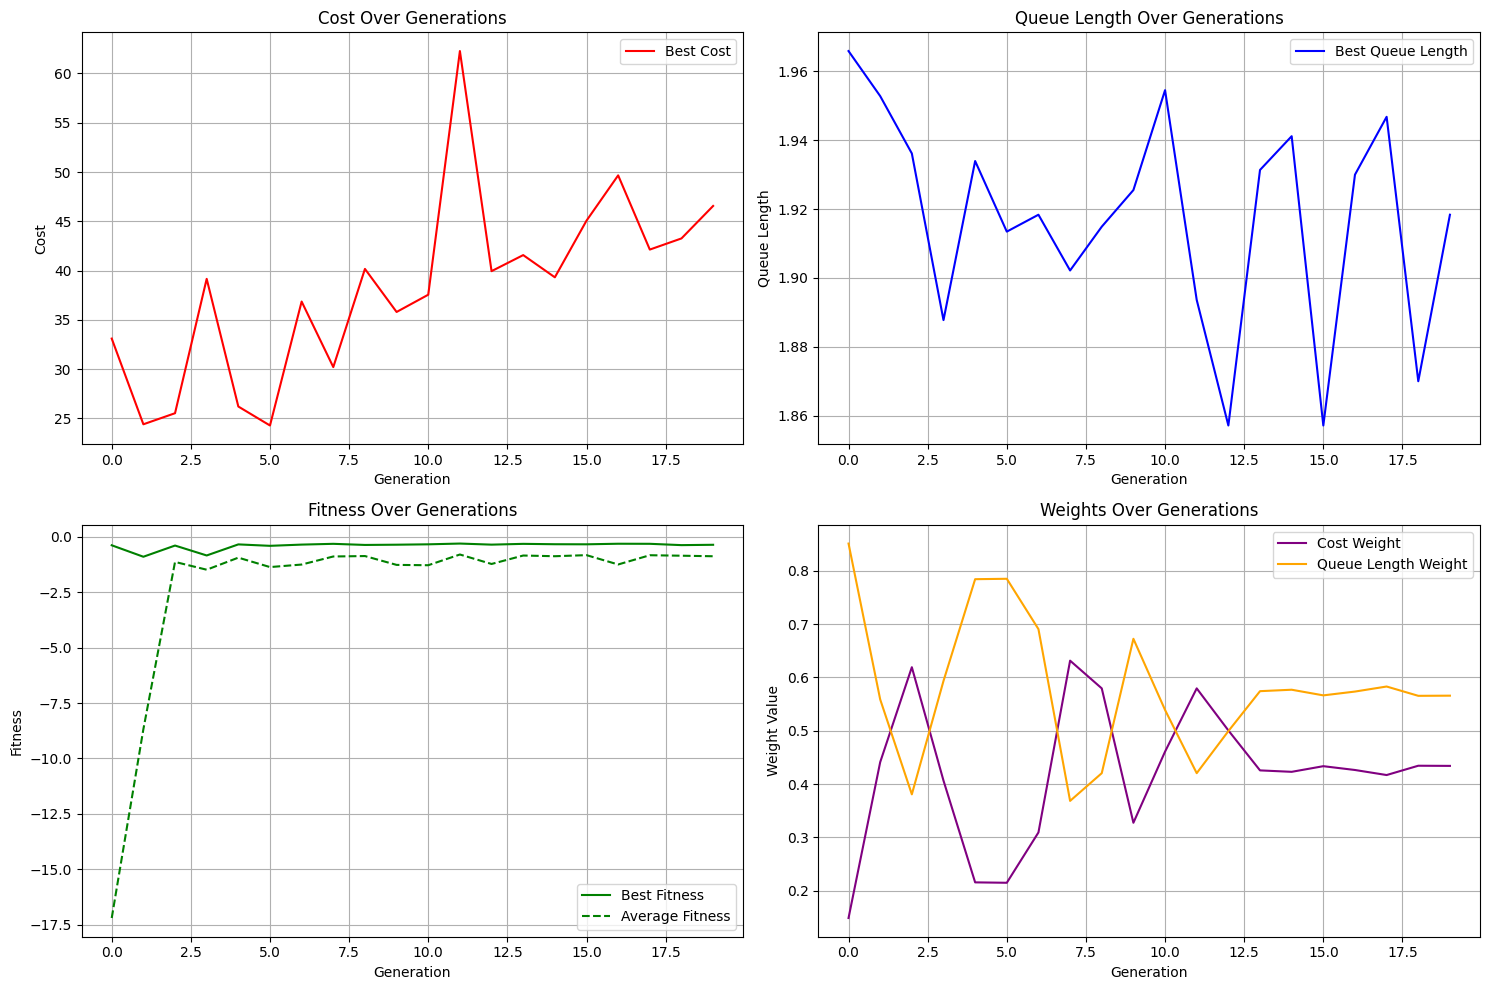

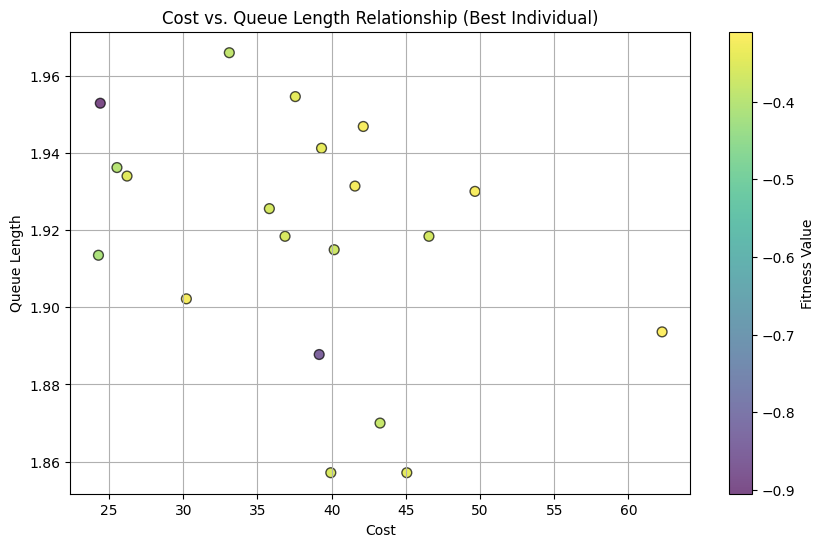


Applying Best Solution to Detailed Simulation with NEW RANDOM jobs
Advanced Manufacturing Scheduling Simulation (Using GA Optimized Parameters)
Weights used - Cost: 0.43, Queue: 0.57
Time 1.21: Job 0 arrived - Queue length: 1
Time 1.21: Job 0 started on Machine 3 - Queue length: 1
Time 1.72: Job 1 arrived - Queue length: 2
Time 4.96: Job 0 completed on Machine 3 - Queue length: 2
Time 4.96: Job 1 started on Machine 3 - Queue length: 1
Time 5.56: Job 2 arrived - Queue length: 2
Time 5.56: Job 2 started on Machine 4 - Queue length: 2
Time 5.63: Job 1 completed on Machine 3 - Queue length: 2
Time 5.71: Job 2 completed on Machine 4 - Queue length: 1
Time 16.40: Job 3 arrived - Queue length: 1
Time 16.40: Job 3 started on Machine 1 - Queue length: 1
Time 23.51: Job 3 completed on Machine 1 - Queue length: 1
Time 23.81: Job 4 arrived - Queue length: 1
Time 23.81: Job 4 started on Machine 2 - Queue length: 1
Time 24.70: Job 5 arrived - Queue length: 2
Time 24.70: Job 5 started on Machine 0 -

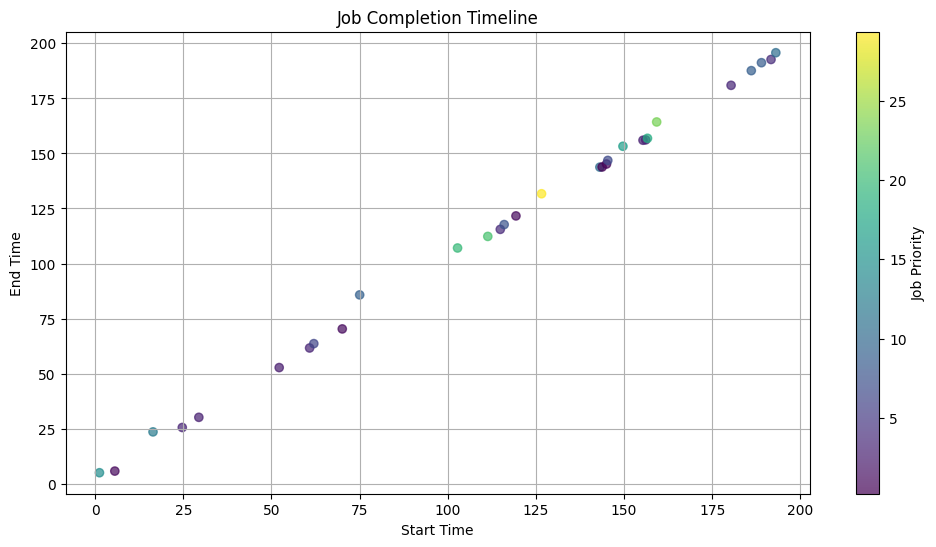

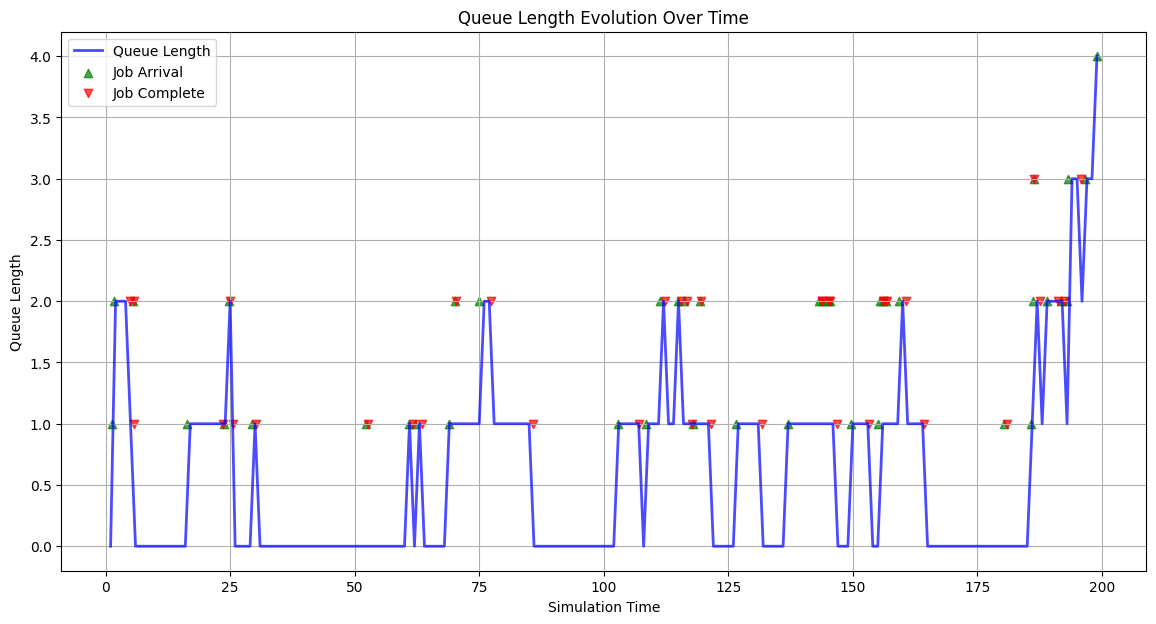


Optimization complete! Best solution has been applied to factory simulation.


In [ ]:
import pandas as pd
import simpy
import random
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import copy

# ==============================
# Simulation Constants and Setup
# ==============================

RANDOM_SEED = 42  # Ensure reproducibility
NUM_MACHINES = 5  # Number of available machines
JOB_INTERVAL = 5  # Average job arrival time
SIM_TIME = 200  # Simulation time
MAX_QUEUE_SIZE = 10  # Machine queue length limit
MAINTENANCE_DURATION = 15  # Time required for maintenance

# Constants from GA
JOB_PRIORITY_RULES = ['FIFO', 'SJF', 'LPT']  # SJF = Shortest Job First, LPT = Longest Processing Time First
ASSIGNMENT_STRATEGIES = ['Random', 'RoundRobin', 'FirstComeFirstServed', 'TaskSpecialization']  # Task assignment strategies

# Correlation constants
C1_energy, C2_energy = 0.5, 0.2  # Energy cost model constants
C1_REPAIR, C2_REPAIR = 0.1, 0.5  # Repair cost model constants
C_maintd = 0.1  # Maintenance duration cost coefficient
C_mainti = 0.2  # Maintenance interval cost coefficient
C_rc = 2.5  # Reliability-related constant
RMAX = 1  # Maximum reliability

# Design variables (for GA optimization)
MACHINE_SPEEDS = [1.0, 1.2, 1.5, 2.0, 2.5]  # Speed multiplier for each machine
MACHINE_MAINTENANCE = [20, 25, 30, 35, 40]  # Maintenance intervals
JOB_PRIORITY_LEVELS = [1, 2, 3]  # Priority categories (1: high, 3: low)
PROCESS_VARIABILITY = [0.8, 1.0, 1.2]  # Variability in job processing time
ENERGY_COSTS = [0.5, 0.75, 1.0, 1.25]  # Energy cost for each machine
FAILURE_PROB = [0.02, 0.05, 0.08]  # Failure probability for each job
REPAIR_TIME = [5, 10, 15]  # Repair time in case of failure
MACHINE_RELIABILITY = [0.9, 0.95, 0.98]  # Probability of machine avoiding failure

# Boundaries of design variables (for GA)
SPEED_BOUNDS = (0.5, 5.0)  # Machine speed range
MAINTENANCE_INTERVAL_BOUNDS = (50, 100)  # Machine maintenance interval range
MAINTENANCE_DURATION_BOUNDS = (1, 5)  # Machine maintenance duration range
PROCESS_VARIABILITY_BOUNDS = (0.01, 0.1)  # Processing variability range
MACHINE_TYPES = ['TypeA', 'TypeB', 'TypeC']  # Machine type categories
REPAIR_TIME_BOUNDS = (20, 50)  # Repair time range

# Define GA parameters
NUM_GENERATIONS = 100  # More complex problems need more generations to converge to a good solution
POPULATION_SIZE = 50  # Rule of thumb is to start from 50-100
MUTATION_RATE = 0.1  # Usually between .001 and .1 (percentage chance that any given gene will mutate during creation of next generation)
CROSSOVER_RATE = 0.7  # Usually between .6 and .9 (percentage chance that any given parent pair will undergo crossover to produce offspring)

# ==============================
# Data Collection
# ==============================
data = {
    'Job': [], 'Machine': [], 'Start_Time': [], 'End_Time': [],
    'Job_Duration': [], 'Job_Type': [], 'Machine_Type': [],
    'Job_Priority': [], 'Machine_Speed': [], 'Actual_Duration': [], 'Energy_Cost': [],
    'Failure': [], 'Repair_Time': [], 'Total_Cost': [], 'Queue_Length': [], 'Time_Stamp': [], 'Event_Type': []
}

# Queue length tracking for visualization
queue_length_history = []

# ==============================
# Job Class Definition
# ==============================

class Job:
    def __init__(self, env, name, duration, job_type, priority, arrival_time=None):
        self.env = env
        self.name = name
        self.id = int(name.split()[1]) if isinstance(name, str) and ' ' in name else name
        self.duration = duration
        self.job_type = job_type
        self.priority = priority  # Higher priority jobs are processed first
        self.arrival_time = arrival_time if arrival_time is not None else env.now
        self.start_time = None
        self.end_time = None
        self.machine = None
        self.status = "Created"  # Created, Waiting, Processing, Completed
        
    def as_dict(self):
        """Return a dictionary representation of the job, used for GA algorithm"""
        return {
            'job_id': self.id,
            'arrival_time': self.arrival_time,
            'processing_time': self.duration,
            'machine_type': self.job_type,
            'priority': self.priority
        }
    
    def process(self, machine):
        """Process the job on the given machine. May be interrupted by maintenance."""
        self.machine = machine
        self.start_time = self.env.now
        self.status = "Processing"
        
        # Record job start
        machine.factory.record_event("JobStart", self)
        
        # Calculate processing parameters
        failure = random.choices([0, 1], [1 - machine.failure_prob, machine.failure_prob])[0]
        repair_time = random.choice(REPAIR_TIME) if failure else 0
        
        # Calculate actual duration using machine speed and processing variability
        variability = random.choice(PROCESS_VARIABILITY)
        actual_duration = self.duration / machine.speed * variability + repair_time
        
        # Calculate total cost
        total_cost = actual_duration * machine.energy_cost
        
        # Record data for job start
        data['Job'].append(self.name)
        data['Machine'].append(machine.name)
        data['Start_Time'].append(self.start_time)
        data['Job_Duration'].append(self.duration)
        data['Job_Type'].append(self.job_type)
        data['Machine_Type'].append(machine.machine_type)
        data['Job_Priority'].append(self.priority)
        data['Machine_Speed'].append(machine.speed)
        data['Energy_Cost'].append(machine.energy_cost)
        data['Failure'].append(failure)
        data['Repair_Time'].append(repair_time)
        data['Total_Cost'].append(total_cost)
        data['Queue_Length'].append(machine.factory.get_total_queue_length())
        data['Time_Stamp'].append(self.env.now)
        data['Event_Type'].append('Start')
        # Add placeholders for end-time data that will be filled in later jobs
        data['End_Time'].append(None)
        data['Actual_Duration'].append(None)
        
        try:
            # Process the job
            yield self.env.timeout(actual_duration)
            
            # Update job status
            self.end_time = self.env.now
            self.status = "Completed"
            
            # Record job completion
            machine.factory.record_event("JobComplete", self)
            
            # Update the end-time data in the last row
            if len(data['End_Time']) > 0:
                data['End_Time'][-1] = self.end_time
                data['Actual_Duration'][-1] = actual_duration
                
        except simpy.Interrupt:
            # Job was interrupted (likely by maintenance)
            
            # Record the interruption
            data['Event_Type'][-1] = 'Interrupted'
            
            # When the job resumes after interruption, we'll need to:
            # 1. Calculate remaining time
            elapsed_time = self.env.now - self.start_time
            remaining_time = actual_duration - elapsed_time
            
            if remaining_time > 0:
                # Resume the job for the remaining time
                try:
                    yield self.env.timeout(remaining_time)
                    
                    # Now the job is completed
                    self.end_time = self.env.now
                    self.status = "Completed"
                    
                    # Record job completion after interruption
                    machine.factory.record_event("JobComplete", self)
                    
                    # Update the end-time data
                    if len(data['End_Time']) > 0:
                        data['End_Time'][-1] = self.end_time
                        data['Actual_Duration'][-1] = self.env.now - self.start_time
                
                except simpy.Interrupt:
                    # If interrupted again, recursively handle it
                    # (This is simplified - in a real implementation, you might want more sophisticated handling)
                    print(f"Job {self.name} was interrupted a second time!")
                    # Let the interrupt propagate up to be handled by the machine's use method
                    raise

    '''
    def process(self, machine):
        self.machine = machine
        self.start_time = self.env.now
        self.status = "Processing"
        
        # Record job start
        machine.factory.record_event("JobStart", self)
        
        # Calculate processing parameters
        failure = random.choices([0, 1], [1 - machine.failure_prob, machine.failure_prob])[0]
        repair_time = random.choice(REPAIR_TIME) if failure else 0
        
        # Calculate actual duration using machine speed and processing variability
        variability = random.choice(PROCESS_VARIABILITY)
        actual_duration = self.duration / machine.speed * variability + repair_time
        
        # Calculate total cost
        total_cost = actual_duration * machine.energy_cost
        
        # Record data for job start
        data['Job'].append(self.name)
        data['Machine'].append(machine.name)
        data['Start_Time'].append(self.start_time)
        data['Job_Duration'].append(self.duration)
        data['Job_Type'].append(self.job_type)
        data['Machine_Type'].append(machine.machine_type)
        data['Job_Priority'].append(self.priority)
        data['Machine_Speed'].append(machine.speed)
        data['Energy_Cost'].append(machine.energy_cost)
        data['Failure'].append(failure)
        data['Repair_Time'].append(repair_time)
        data['Total_Cost'].append(total_cost)
        data['Queue_Length'].append(machine.factory.get_total_queue_length())
        data['Time_Stamp'].append(self.env.now)
        data['Event_Type'].append('Start')
        # Add placeholders for end-time data that will be filled in later jobs
        data['End_Time'].append(None)
        data['Actual_Duration'].append(None)
        
        # Process the job
        yield self.env.timeout(actual_duration)
        
        # Update job status
        self.end_time = self.env.now
        self.status = "Completed"
        
        # Record job completion
        machine.factory.record_event("JobComplete", self)
        
        # Update the end-time data in the last row (that we just added above)
        if len(data['End_Time']) > 0:
            data['End_Time'][-1] = self.end_time
            data['Actual_Duration'][-1] = actual_duration
'''
# ==============================
# Machine Class Definition
# ==============================
class Machine:
    def __init__(self, env, name, machine_type, factory=None, speed=None, maintenance_interval=None, energy_cost=None, 
                 failure_prob=None, reliability=None, maintenance_duration=None, process_variability=None):
        self.env = env
        self.name = name
        self.id = int(name.split()[1]) if isinstance(name, str) and ' ' in name else name
        self.machine_type = machine_type
        self.factory = factory  # Reference to the factory for system-wide tracking
        self.speed = speed if speed is not None else random.choice(MACHINE_SPEEDS)
        self.maintenance_interval = maintenance_interval if maintenance_interval is not None else random.choice(MACHINE_MAINTENANCE)
        self.energy_cost = energy_cost if energy_cost is not None else random.choice(ENERGY_COSTS)
        self.failure_prob = failure_prob if failure_prob is not None else random.choice(FAILURE_PROB)
        self.reliability = reliability if reliability is not None else random.choice(MACHINE_RELIABILITY)
        self.maintenance_duration = maintenance_duration if maintenance_duration is not None else MAINTENANCE_DURATION
        self.process_variability = process_variability if process_variability is not None else random.choice(PROCESS_VARIABILITY)
        self.machine = simpy.PriorityResource(env, capacity=1)
        self.current_job = None
        self.processing_job = False
        self.in_maintenance = False  # Flag to track maintenance status
        self.maintenance_process = self.env.process(self.maintenance_cycle())
        self.current_job_process = None  # Keep track of the current job process
    
    def as_dict(self):
        """Return a dictionary representation of the machine, used for GA algorithm"""
        return {
            'machine_id': self.id,
            'machine_type': self.machine_type,
            'machine_speed': self.speed,
            'machine_reliability': self.reliability
        }
    
    def use(self, job):
        with self.machine.request(priority=job.priority) as request:
            yield request
            
            # Skip processing if maintenance interrupts before processing begins
            if self.in_maintenance:
                print(f"Job {job.name} waiting for {self.name} to complete maintenance at {self.env.now}")
                yield self.env.process(self.wait_for_maintenance_completion())
            
            self.processing_job = True
            self.current_job = job
            try:
                # Store the job process so we can interrupt it if needed
                self.current_job_process = self.env.process(job.process(self))
                yield self.current_job_process
            except simpy.Interrupt:
                # This will be triggered when maintenance interrupts the job
                print(f"Job {job.name} on {self.name} was interrupted by maintenance at {self.env.now}")
                # The job will be resumed after maintenance in the maintenance_cycle method
                pass
            finally:
                self.current_job = None
                self.processing_job = False
                self.current_job_process = None
    
    def wait_for_maintenance_completion(self):
        """Wait until maintenance is complete"""
        while self.in_maintenance:
            yield self.env.timeout(1)  # Check every time unit
    
    def maintenance_cycle(self):
        while True:
            # Wait until next maintenance is due
            yield self.env.timeout(self.maintenance_interval)
            
            print(f'{self.name} is due for maintenance at {self.env.now}')
            
            # Request exclusive access to the machine
            with self.machine.request(priority=-1000) as req:  # Super high priority (negative is higher)
                yield req
                
                self.in_maintenance = True
                print(f'{self.name} started maintenance at {self.env.now}')
                
                # If there's a job in progress, interrupt it
                if self.current_job_process is not None and self.current_job_process.is_alive:
                    self.current_job_process.interrupt()
                    
                # Perform maintenance
                yield self.env.timeout(self.maintenance_duration)
                
                print(f'{self.name} completed maintenance at {self.env.now}')
                self.in_maintenance = False
                
                # Job will automatically resume once maintenance releases the resource
'''
class Machine:
    def __init__(self, env, name, machine_type, factory=None, speed=None, maintenance_interval=None, energy_cost=None, 
                 failure_prob=None, reliability=None, maintenance_duration=None, process_variability=None):
        self.env = env
        self.name = name
        self.id = int(name.split()[1]) if isinstance(name, str) and ' ' in name else name
        self.machine_type = machine_type
        self.factory = factory  # Reference to the factory for system-wide tracking
        self.speed = speed if speed is not None else random.choice(MACHINE_SPEEDS)
        self.maintenance_interval = maintenance_interval if maintenance_interval is not None else random.choice(MACHINE_MAINTENANCE)
        self.energy_cost = energy_cost if energy_cost is not None else random.choice(ENERGY_COSTS)
        self.failure_prob = failure_prob if failure_prob is not None else random.choice(FAILURE_PROB)
        self.reliability = reliability if reliability is not None else random.choice(MACHINE_RELIABILITY)
        self.maintenance_duration = maintenance_duration if maintenance_duration is not None else MAINTENANCE_DURATION
        self.process_variability = process_variability if process_variability is not None else random.choice(PROCESS_VARIABILITY)
        self.machine = simpy.PriorityResource(env, capacity=1)
        self.current_job = None
        self.processing_job = False
        self.env.process(self.maintenance_cycle())
    
    def as_dict(self):
        """Return a dictionary representation of the machine, used for GA algorithm"""
        return {
            'machine_id': self.id,
            'machine_type': self.machine_type,
            'machine_speed': self.speed,
            'machine_reliability': self.reliability
        }
    
    def use(self, job):
        with self.machine.request(priority=job.priority) as request:
            yield request
            self.processing_job = True
            self.current_job = job
            yield self.env.process(job.process(self))
            self.current_job = None
            self.processing_job = False
    
    def maintenance_cycle(self):
        while True:
            yield self.env.timeout(self.maintenance_interval)
            print(f'{self.name} is under maintenance at {self.env.now}')
            yield self.env.timeout(self.maintenance_duration)
'''
# ==============================
# Factory Class Definition
# ==============================

class Factory:
    def __init__(self, env, num_machines, assignment_strategy='Random', priority_rule='FIFO'):
        self.env = env
        self.assignment_strategy = assignment_strategy
        self.priority_rule = priority_rule
        
        # Job tracking
        self.jobs = []  # All jobs
        self.waiting_jobs = []  # Jobs waiting to be assigned
        self.processing_jobs = []  # Jobs currently being processed
        self.completed_jobs = []  # Jobs that have completed
        
        # Create machines
        self.machines = []
        for i in range(num_machines):
            machine = Machine(
                env=env,
                name=f'Machine {i}',
                machine_type=random.choice(MACHINE_TYPES),
                factory=self
            )
            self.machines.append(machine)
        
        # Start queue monitoring
        self.env.process(self.monitor_queue())
    
    def job_generator(self, job_list=None):
        """Generate jobs from a predefined list or randomly"""
        if job_list:
            for job_info in job_list:
                # If there's a preset arrival time, wait until that time point
                if 'arrival_time' in job_info and job_info['arrival_time'] > self.env.now:
                    yield self.env.timeout(job_info['arrival_time'] - self.env.now)
                
                # Create job object
                job = Job(
                    self.env, 
                    f"Job {job_info.get('job_id', len(self.jobs))}", 
                    job_info.get('processing_time', random.expovariate(1.0 / 10)),
                    job_info.get('machine_type', random.choice(['Type X', 'Type Y', 'Type Z'])),
                    job_info.get('priority', random.choice(JOB_PRIORITY_LEVELS)),
                    job_info.get('arrival_time', self.env.now)
                )
                
                # Add to job tracking
                self.jobs.append(job)
                self.waiting_jobs.append(job)
                job.status = "Waiting"
                
                # Record job arrival
                self.record_event("JobArrival", job)
                
                # Assign the job to a machine
                self.assign_job(job)
        else:
            i = 0
            while True:
                yield self.env.timeout(random.expovariate(1.0 / JOB_INTERVAL))
                job_duration = random.expovariate(1.0 / 10)
                job_type = random.choice(['Type X', 'Type Y', 'Type Z'])
                job_priority = random.choice(JOB_PRIORITY_LEVELS)
                job = Job(self.env, f'Job {i}', job_duration, job_type, job_priority)
                
                # Add to job tracking
                self.jobs.append(job)
                self.waiting_jobs.append(job)
                job.status = "Waiting"
                
                # Record job arrival
                self.record_event("JobArrival", job)
                
                # Assign the job to a machine
                self.assign_job(job)
                i += 1
                
    def assign_job(self, job):
        """Assign job to machine based on the selected assignment strategy"""
        
        # First, filter out machines currently in maintenance if desired
        # (You can remove this filter if you want jobs to be queued behind machines in maintenance)
        available_machines = [m for m in self.machines if not m.in_maintenance]
        
        # If all machines are in maintenance, use all machines (jobs will wait in queue)
        if not available_machines:
            available_machines = self.machines
            print(f"Warning: All machines in maintenance. Job {job.name} will be queued until a machine becomes available.")
        
        # Choose machine based on strategy
        if self.assignment_strategy == 'Random':
            machine = random.choice(available_machines)
        elif self.assignment_strategy == 'RoundRobin':
            machine = available_machines[len(self.jobs) % len(available_machines)]
        elif self.assignment_strategy == 'FirstComeFirstServed':
            machine = min(available_machines, key=lambda m: len(m.machine.queue))
        elif self.assignment_strategy == 'TaskSpecialization':
            # Find machines that match the job type
            compatible_machines = [m for m in available_machines if m.machine_type == job.job_type]
            if compatible_machines:
                machine = random.choice(compatible_machines)
            else:
                machine = random.choice(available_machines)  # If no compatible machines, choose randomly
        else:
            machine = min(available_machines, key=lambda m: len(m.machine.queue))
        
        # Apply priority rule
        if self.priority_rule == 'FIFO':
            # First in, first out, already the default
            pass
        elif self.priority_rule == 'SJF':
            # Shortest Job First
            job.priority = job.duration  # Shorter jobs get higher priority
        elif self.priority_rule == 'LPT':
            # Longest Processing Time first
            job.priority = -job.duration  # Longer jobs get higher priority
        
        # Start machine process
        self.env.process(machine.use(job))
    '''
    def assign_job(self, job):
        """Assign job to machine based on the selected assignment strategy"""
        
        # Choose machine based on strategy
        if self.assignment_strategy == 'Random':
            machine = random.choice(self.machines)
        elif self.assignment_strategy == 'RoundRobin':
            machine = self.machines[len(self.jobs) % len(self.machines)]
        elif self.assignment_strategy == 'FirstComeFirstServed':
            machine = min(self.machines, key=lambda m: len(m.machine.queue))
        elif self.assignment_strategy == 'TaskSpecialization':
            # Find machines that match the job type
            compatible_machines = [m for m in self.machines if m.machine_type == job.job_type]
            if compatible_machines:
                machine = random.choice(compatible_machines)
            else:
                machine = random.choice(self.machines)  # If no compatible machines, choose randomly
        else:
            machine = min(self.machines, key=lambda m: len(m.machine.queue))
        
        # Apply priority rule
        if self.priority_rule == 'FIFO':
            # First in, first out, already the default
            pass
        elif self.priority_rule == 'SJF':
            # Shortest Job First
            job.priority = job.duration  # Shorter jobs get higher priority
        elif self.priority_rule == 'LPT':
            # Longest Processing Time first
            job.priority = -job.duration  # Longer jobs get higher priority
        
        # Start machine process
        self.env.process(machine.use(job))
    '''

    def record_event(self, event_type, job):
        """Record event data with current queue length"""
        current_time = self.env.now
        current_queue_length = self.get_total_queue_length()
        
        if event_type == "JobArrival":
            print(f"Time {current_time:.2f}: {job.name} arrived - Queue length: {current_queue_length}")
            # Update job status
            if job not in self.waiting_jobs:
                self.waiting_jobs.append(job)
            job.status = "Waiting"
            
        elif event_type == "JobStart":
            print(f"Time {current_time:.2f}: {job.name} started on {job.machine.name} - Queue length: {current_queue_length}")
            # Update job status
            if job in self.waiting_jobs:
                self.waiting_jobs.remove(job)
            self.processing_jobs.append(job)
            
        elif event_type == "JobComplete":
            print(f"Time {current_time:.2f}: {job.name} completed on {job.machine.name} - Queue length: {current_queue_length}")
            # Update job status
            if job in self.processing_jobs:
                self.processing_jobs.remove(job)
            self.completed_jobs.append(job)
        
        # Record queue length history for visualization
        queue_length_history.append((current_time, current_queue_length, event_type))
        
        # Add to data collection
        data['Job'].append(job.name)
        data['Machine'].append(job.machine.name if job.machine else "None")
        data['Time_Stamp'].append(current_time)
        data['Queue_Length'].append(current_queue_length)
        data['Event_Type'].append(event_type)
    
    def get_total_queue_length(self):
        """Get total number of jobs waiting or in process but not completed"""
        return len(self.waiting_jobs) + len(self.processing_jobs)
    
    def monitor_queue(self):
        """Periodically monitor queue length"""
        monitor_interval = 1
        while True:
            yield self.env.timeout(monitor_interval)
            current_queue_length = self.get_total_queue_length()
            queue_length_history.append((self.env.now, current_queue_length, "Monitor"))
            
            # Record monitor data
            data['Job'].append("Monitor")
            data['Machine'].append("None")
            data['Time_Stamp'].append(self.env.now)
            data['Queue_Length'].append(current_queue_length)
            data['Event_Type'].append("Monitor")

# ==============================
# Genetic Algorithm Related Functions
# ==============================

def initialize_population():
    """Initialize population"""
    population = []
    for _ in range(POPULATION_SIZE):
        # Randomly initialize machine parameters and allocation strategy, including fitness weights
        individual = {
            'speed': random.uniform(*SPEED_BOUNDS),
            'maintenance_interval': random.uniform(*MAINTENANCE_INTERVAL_BOUNDS),
            'maintenance_duration': random.uniform(*MAINTENANCE_DURATION_BOUNDS),
            'process_variability': random.uniform(*PROCESS_VARIABILITY_BOUNDS),
            'machine_type': random.choice(MACHINE_TYPES),
            'assignment_strategy': random.choice(ASSIGNMENT_STRATEGIES),
            'priority_rule': random.choice(JOB_PRIORITY_RULES),
            'repair_time': random.uniform(*REPAIR_TIME_BOUNDS),
            'weight_cost': random.uniform(0.1, 0.9)  # Cost weight, queue weight will be 1-weight_cost
        }
        population.append(individual)
    return population

def total_cost(individual):
    """Calculate total cost, objective is to minimize"""
    # Cost calculation based on machine speed and energy cost per unit time
    energy_cost = C1_energy * individual['speed']**3 + C2_energy  # Energy cost model
    repair_cost = C1_REPAIR * individual['repair_time']**2 + C2_REPAIR  # Repair cost model
    maintenance_cost = C_maintd * individual['maintenance_duration']  # Maintenance cost
    reliability = RMAX * (1 - np.exp(-C_mainti * individual['maintenance_interval']))
    total_cost = energy_cost + maintenance_cost + C_rc*(1-(reliability/RMAX))*(repair_cost)  # If reliability is close to RMAX, repair cost should be lower
    return total_cost

def simulate_queue_evolution(individual, job_list, machine_list, sim_time=150):
    """
    Simulate the queue length evolution over time with the given parameters.
    This is a simplified simulation that considers job processing and completion.
    """
    # Create machine objects from machine_list with parameters from individual
    machines = []
    for m in machine_list:
        machine = {
            'id': m['machine_id'],
            'type': m['machine_type'],
            'speed': individual['speed'],  # Use speed from individual
            'queue': [],  # Current queue
            'current_job': None,  # Current job being processed
            'end_time': 0  # Time when current job will complete
        }
        machines.append(machine)
    
    # Create a copy of job list and sort by arrival time
    jobs = copy.deepcopy(job_list)
    jobs.sort(key=lambda x: x['arrival_time'])
    
    # Job status tracking
    waiting_jobs = []  # Jobs waiting to be assigned
    processing_jobs = []  # Jobs currently being processed
    completed_jobs = []  # Jobs that have completed
    
    # Simulation time process
    current_time = 0
    time_points = []
    queue_lengths = []
    max_queue_observed = 0  # Track maximum observed queue length
    
    # Add more randomness to enhance sensitivity
    variability_factor = random.uniform(0.8, 1.2)  # Add random variability factor
    
    while current_time < sim_time and (jobs or waiting_jobs or processing_jobs):
        # Determine next event time
        next_job_arrival = jobs[0]['arrival_time'] if jobs else float('inf')
        next_job_completion = min([m['end_time'] for m in machines if m['current_job']], default=float('inf'))
        
        # Advance to next event
        next_event_time = min(next_job_arrival, next_job_completion)
        if next_event_time == float('inf'):
            # No more events to process
            break
            
        current_time = next_event_time
        
        # Process job arrivals
        while jobs and jobs[0]['arrival_time'] <= current_time:
            new_job = jobs.pop(0)
            # Add randomness to processing time
            new_job['processing_time'] *= random.uniform(0.9, 1.1) * variability_factor  
            waiting_jobs.append(new_job)
        
        # Process job completions
        for machine in machines:
            if machine['current_job'] and machine['end_time'] <= current_time:
                completed_job = machine['current_job']
                completed_jobs.append(completed_job)
                processing_jobs.remove(completed_job)
                machine['current_job'] = None
        
        # Assign waiting jobs to idle machines
        if waiting_jobs:
            # Choose based on assignment strategy
            if individual['assignment_strategy'] == 'Random':
                random.shuffle(waiting_jobs)
                # Try to assign each waiting job
                remaining_waiting_jobs = []
                for job in waiting_jobs:
                    # Find idle machines
                    idle_machines = [m for m in machines if not m['current_job']]
                    if idle_machines:
                        chosen_machine = random.choice(idle_machines)
                        # Calculate processing time, add more randomness
                        processing_time = job['processing_time'] / individual['speed'] * random.uniform(0.8, 1.2)
                        # Update machine
                        chosen_machine['current_job'] = job
                        chosen_machine['end_time'] = current_time + processing_time
                        # Update job status
                        processing_jobs.append(job)
                    else:
                        remaining_waiting_jobs.append(job)
                waiting_jobs = remaining_waiting_jobs
            
            # Other assignment strategies... (omitted, same as original code)
        
        # Record queue length at this time point
        current_queue_length = len(waiting_jobs) + len(processing_jobs)
        max_queue_observed = max(max_queue_observed, current_queue_length)  # Update maximum observed queue length
        
        # Record queue status more frequently
        if random.random() < 0.8:  # Record data at 80% of event points
            time_points.append(current_time)
            queue_lengths.append(current_queue_length)
    
    # Calculate queue metrics
    if queue_lengths:
        avg_queue_length = sum(queue_lengths) / len(queue_lengths)
        max_queue_length = max(queue_lengths)
        final_queue_length = queue_lengths[-1]
        
        # Use weighted calculation with higher weight for maximum queue length
        weighted_queue_length = 0.5 * avg_queue_length + 0.5 * max_queue_length
    else:
        avg_queue_length = 0
        max_queue_length = 0
        final_queue_length = 0
        weighted_queue_length = 0
    
    return {
        'avg_queue_length': avg_queue_length,
        'max_queue_length': max_queue_length,
        'weighted_queue_length': weighted_queue_length,  # New weighted queue length
        'final_queue_length': final_queue_length,
        'time_points': time_points,
        'queue_lengths': queue_lengths
    }

def queue_length(individual, job_list, machine_list):
    """Calculate queue length, objective is to minimize"""
    # Use more realistic method to simulate queue evolution
    queue_sim_results = simulate_queue_evolution(individual, job_list, machine_list)
    
    # Now return weighted queue length instead of average queue length
    return queue_sim_results['weighted_queue_length']  # Use weighted value

def objective_function(individual, job_list, machine_list):
    """Multi-objective function (both cost and queue length need to be minimized)"""
    cost = total_cost(individual)
    queue_len = queue_length(individual, job_list, machine_list)
    return cost, queue_len

# Maximum and minimum values for normalization, will be dynamically updated during evaluation
COST_MIN = float('inf')
COST_MAX = float('-inf')
QUEUE_MIN = float('inf')
QUEUE_MAX = float('-inf')

def normalize_cost(cost):
    """Normalize cost value to 0-1 range"""
    global COST_MIN, COST_MAX
    # Update global min/max values
    COST_MIN = min(COST_MIN, cost)
    COST_MAX = max(COST_MAX, cost)
    
    # Prevent division by zero
    if COST_MAX == COST_MIN:
        return 0.5  # If all values are the same, return 0.5
    
    # Normalize to 0-1 range
    return (cost - COST_MIN) / (COST_MAX - COST_MIN)

def normalize_queue_length(queue_len):
    """Normalize queue length to 0-1 range"""
    global QUEUE_MIN, QUEUE_MAX
    # Update global min/max values
    QUEUE_MIN = min(QUEUE_MIN, queue_len)
    QUEUE_MAX = max(QUEUE_MAX, queue_len)
    
    # Prevent division by zero
    if QUEUE_MAX == QUEUE_MIN:
        return 0.5  # If all values are the same, return 0.5
    
    # Normalize to 0-1 range
    return (queue_len - QUEUE_MIN) / (QUEUE_MAX - QUEUE_MIN)

def fitness(individual, job_list, machine_list):
    """Calculate fitness of an individual, based on weighted average of normalized cost and queue length"""
    cost, queue_len = objective_function(individual, job_list, machine_list)
    
    # Normalized values
    norm_cost = normalize_cost(cost)
    norm_queue_len = normalize_queue_length(queue_len)
    
    # Get weights from individual, or use default if not present
    weight_cost = individual.get('weight_cost', 0.5)
    weight_queue = 1.0 - weight_cost  # Ensure weights sum to 1
    
    # Calculate weighted average (reversed, because we want to minimize these values)
    weighted_score = weight_cost * norm_cost + weight_queue * norm_queue_len
    
    # Return fitness value (higher is better)
    return 1.0 - weighted_score  # Convert to "higher is better" fitness value

def crossover(parent1, parent2):
    """Crossover operation"""
    if random.random() < CROSSOVER_RATE:
        child1 = parent1.copy()
        child2 = parent2.copy()
        
        # Mix numeric parameters
        for key in ['speed', 'maintenance_interval', 'maintenance_duration', 'process_variability', 'repair_time', 'weight_cost']:
            if key in parent1 and key in parent2:
                alpha = random.random()  # Random mixing factor between 0 and 1
                temp1 = child1[key]
                temp2 = child2[key]
                child1[key] = alpha * temp1 + (1 - alpha) * temp2
                child2[key] = alpha * temp2 + (1 - alpha) * temp1
        
        # Randomly swap categorical parameters
        for key in ['machine_type', 'assignment_strategy', 'priority_rule']:
            if random.random() < 0.5:
                temp = child1[key]
                child1[key] = child2[key]
                child2[key] = temp
                
        return child1, child2
    return parent1.copy(), parent2.copy()

def mutate(individual):
    """Mutation operation"""
    if random.random() < MUTATION_RATE:
        # Mutate machine parameters by randomly selecting a variable and changing it
        mutation_point = random.choice(list(individual.keys()))
        if mutation_point == 'speed':
            individual[mutation_point] = random.uniform(*SPEED_BOUNDS)
        elif mutation_point == 'maintenance_interval':
            individual[mutation_point] = random.uniform(*MAINTENANCE_INTERVAL_BOUNDS)
        elif mutation_point == 'maintenance_duration':
            individual[mutation_point] = random.uniform(*MAINTENANCE_DURATION_BOUNDS)
        elif mutation_point == 'repair_time':
            individual[mutation_point] = random.uniform(*REPAIR_TIME_BOUNDS)
        elif mutation_point == 'process_variability':
            individual[mutation_point] = random.uniform(*PROCESS_VARIABILITY_BOUNDS)
        elif mutation_point == 'machine_type':
            individual[mutation_point] = random.choice(MACHINE_TYPES)
        elif mutation_point == 'assignment_strategy':
            individual[mutation_point] = random.choice(ASSIGNMENT_STRATEGIES)
        elif mutation_point == 'priority_rule':
            individual[mutation_point] = random.choice(JOB_PRIORITY_RULES)
        elif mutation_point == 'weight_cost':
            individual[mutation_point] = random.uniform(0.1, 0.9)  # Mutate weight value
    return individual

def tournament_selection(population, job_list, machine_list, tournament_size=5):
    """Tournament selection, selects the individual with highest fitness"""
    tournament = random.sample(population, min(tournament_size, len(population)))
    return max(tournament, key=lambda ind: fitness(ind, job_list, machine_list))

def genetic_algorithm(job_list, machine_list, num_generations=NUM_GENERATIONS):
    """Genetic algorithm main loop"""
    # Initialize population
    pop = initialize_population()
    
    # Track best individual
    best_individual = None
    best_fitness = float('-inf')
    
    # For recording information about each generation
    generation_stats = []

    for generation in range(num_generations):
        # Calculate fitness for all individuals
        fitness_values = [fitness(ind, job_list, machine_list) for ind in pop]
        
        # Record the best individual for this generation
        current_best_idx = fitness_values.index(max(fitness_values))
        current_best = pop[current_best_idx]
        
        if best_individual is None or fitness(current_best, job_list, machine_list) > best_fitness:
            best_individual = current_best.copy()
            best_fitness = fitness(current_best, job_list, machine_list)
        
        # Create new generation
        new_pop = []
        for _ in range(POPULATION_SIZE // 2):
            # Use tournament selection
            parent1 = tournament_selection(pop, job_list, machine_list)
            parent2 = tournament_selection(pop, job_list, machine_list)
            
            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_pop.extend([child1, child2])

        # Ensure new population size is correct
        pop = new_pop[:POPULATION_SIZE]
        
        # Get details for the current best individual
        cost, queue_len = objective_function(current_best, job_list, machine_list)
        weight_cost = current_best.get('weight_cost', 0.5)
        weight_queue = 1.0 - weight_cost
        
        # Record statistics
        gen_info = {
            'generation': generation,
            'best_cost': cost,
            'best_queue_length': queue_len,
            'best_fitness': max(fitness_values),
            'avg_fitness': sum(fitness_values) / len(fitness_values),
            'weight_cost': weight_cost,
            'weight_queue': weight_queue
        }
        generation_stats.append(gen_info)
        
        # Print progress
        print(f"Generation {generation}:")
        print(f"  Best cost: {cost:.2f} (weight: {weight_cost:.2f})")
        print(f"  Best queue length: {queue_len:.2f} (weight: {weight_queue:.2f})")
        print(f"  Best fitness: {max(fitness_values):.4f}, Average fitness: {sum(fitness_values) / len(fitness_values):.4f}")
        print(f"  Normalization range - Cost: [{COST_MIN:.2f}, {COST_MAX:.2f}], Queue: [{QUEUE_MIN:.2f}, {QUEUE_MAX:.2f}]")
    
    # Return final population, best individual, and generation statistics
    return pop, best_individual, generation_stats

# ==============================
# Data Visualization Functions
# ==============================

def visualize_simulation_results(df):
    """Visualize simulation results"""
    # Ensure all data columns are numeric
    for col in ['Start_Time', 'End_Time', 'Time_Stamp', 'Queue_Length']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Figure 1: Job completion timeline (if applicable)
    if 'Start_Time' in df.columns and 'End_Time' in df.columns and 'Job_Priority' in df.columns:
        job_data = df.dropna(subset=['Start_Time', 'End_Time', 'Job_Priority'])
        if not job_data.empty:
            plt.figure(figsize=(12, 6))
            plt.scatter(job_data['Start_Time'], job_data['End_Time'], c=job_data['Job_Priority'], cmap='viridis', alpha=0.7)
            plt.colorbar(label='Job Priority')
            plt.xlabel('Start Time')
            plt.ylabel('End Time')
            plt.title('Job Completion Timeline')
            plt.grid(True)
            plt.show()

    # Figure 2: Queue length over time - from recorded history
    plt.figure(figsize=(14, 7))
    
    # Convert queue length history to DataFrame for easier plotting
    history_df = pd.DataFrame(queue_length_history, columns=['Time', 'Queue_Length', 'Event_Type'])
    
    # Sort by time for proper plotting
    history_df = history_df.sort_values('Time')
    
    # Plot line from monitor points for smoother visualization
    monitor_points = history_df[history_df['Event_Type'] == 'Monitor']
    job_arrival_points = history_df[history_df['Event_Type'] == 'JobArrival']
    job_complete_points = history_df[history_df['Event_Type'] == 'JobComplete']
    
    # Plot main line using monitor points
    plt.plot(monitor_points['Time'], monitor_points['Queue_Length'], 'b-', alpha=0.7, linewidth=2, label='Queue Length')
    
    # Add markers for job events
    plt.scatter(job_arrival_points['Time'], job_arrival_points['Queue_Length'], color='green', marker='^', alpha=0.7, label='Job Arrival')
    plt.scatter(job_complete_points['Time'], job_complete_points['Queue_Length'], color='red', marker='v', alpha=0.7, label='Job Complete')
    
    plt.xlabel('Simulation Time')
    plt.ylabel('Queue Length')
    plt.title('Queue Length Evolution Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    '''# Figure 3: Pie chart of job status at end of simulation
    if 'Event_Type' in df.columns:
        job_status_counts = df.groupby('Event_Type').size()
        plt.figure(figsize=(10, 7))
        plt.pie(job_status_counts, labels=job_status_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
        plt.title('Job Event Distribution')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.show()'''

def visualize_ga_results(generation_stats):
    """Visualize genetic algorithm results"""
    if not generation_stats:
        print("No genetic algorithm results to visualize")
        return
    
    generations = [stat['generation'] for stat in generation_stats]
    costs = [stat['best_cost'] for stat in generation_stats]
    queue_lengths = [stat['best_queue_length'] for stat in generation_stats]
    fitnesses = [stat['best_fitness'] for stat in generation_stats]
    avg_fitnesses = [stat['avg_fitness'] for stat in generation_stats]
    weight_costs = [stat['weight_cost'] for stat in generation_stats]
    
    # Print more statistics
    print("\nQueue Length Statistics:")
    print(f"  Initial Queue Length: {queue_lengths[0]:.2f}")
    print(f"  Final Queue Length: {queue_lengths[-1]:.2f}")
    print(f"  Min Queue Length: {min(queue_lengths):.2f}")
    print(f"  Max Queue Length: {max(queue_lengths):.2f}")
    print(f"  Delta Queue Length: {queue_lengths[-1] - queue_lengths[0]:.2f}")

    # Plot cost and queue length trends over generations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cost over generations
    axes[0, 0].plot(generations, costs, 'r-', label='Best Cost')
    axes[0, 0].set_title('Cost Over Generations')
    axes[0, 0].set_xlabel('Generation')
    axes[0, 0].set_ylabel('Cost')
    axes[0, 0].grid(True)
    axes[0, 0].legend()
    
    # Queue length over generations
    axes[0, 1].plot(generations, queue_lengths, 'b-', label='Best Queue Length')
    axes[0, 1].set_title('Queue Length Over Generations')
    axes[0, 1].set_xlabel('Generation')
    axes[0, 1].set_ylabel('Queue Length')
    axes[0, 1].grid(True)
    axes[0, 1].legend()
    
    # Fitness over generations
    axes[1, 0].plot(generations, fitnesses, 'g-', label='Best Fitness')
    axes[1, 0].plot(generations, avg_fitnesses, 'g--', label='Average Fitness')
    axes[1, 0].set_title('Fitness Over Generations')
    axes[1, 0].set_xlabel('Generation')
    axes[1, 0].set_ylabel('Fitness')
    axes[1, 0].grid(True)
    axes[1, 0].legend()
    
    # Weights over generations
    axes[1, 1].plot(generations, weight_costs, 'purple', label='Cost Weight')
    axes[1, 1].plot(generations, [1-w for w in weight_costs], 'orange', label='Queue Length Weight')
    axes[1, 1].set_title('Weights Over Generations')
    axes[1, 1].set_xlabel('Generation')
    axes[1, 1].set_ylabel('Weight Value')
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot scatter plot of cost vs. queue length, color indicating fitness
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(costs, queue_lengths, c=fitnesses, cmap='viridis', 
                         s=50, alpha=0.7, edgecolors='black')
    plt.colorbar(scatter, label='Fitness Value')
    plt.title('Cost vs. Queue Length Relationship (Best Individual)')
    plt.xlabel('Cost')
    plt.ylabel('Queue Length')
    plt.grid(True)
    plt.show()

# ==============================
# Apply GA solution to simulation
# ==============================

def apply_ga_solution_to_simulation(best_solution, job_list=None):
    """Apply the best solution found by GA to the factory simulation"""
    print('Advanced Manufacturing Scheduling Simulation (Using GA Optimized Parameters)')
    print(f"Weights used - Cost: {best_solution.get('weight_cost', 0.5):.2f}, Queue: {1-best_solution.get('weight_cost', 0.5):.2f}")
    
    # Reset data collection
    for key in data:
        data[key] = []
    global queue_length_history
    queue_length_history = []
    
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    
    # Create factory with optimized parameters
    factory = Factory(
        env=env,
        num_machines=NUM_MACHINES,
        assignment_strategy=best_solution.get('assignment_strategy', 'Random'),
        priority_rule=best_solution.get('priority_rule', 'FIFO')
    )
    
    # Update machine parameters with optimized values
    for machine in factory.machines:
        machine.speed = best_solution.get('speed', machine.speed)
        machine.maintenance_interval = best_solution.get('maintenance_interval', machine.maintenance_interval)
        machine.maintenance_duration = best_solution.get('maintenance_duration', machine.maintenance_duration)
        machine.process_variability = best_solution.get('process_variability', machine.process_variability)
        machine.machine_type = best_solution.get('machine_type', machine.machine_type)
    
    # Start job generator with provided job list
    env.process(factory.job_generator(job_list))
    
    # Run simulation
    env.run(until=SIM_TIME)
    
    # Process data
    if data['Time_Stamp']:  # Check if any data was collected
        # Check for inconsistent array lengths
        lengths = {key: len(value) for key, value in data.items()}
        print("Data array lengths:")
        for key, length in lengths.items():
            print(f"  {key}: {length}")
        
        # Find if there's any inconsistency
        if len(set(lengths.values())) > 1:
            print("Warning: Data arrays have inconsistent lengths. Fixing before creating DataFrame.")
            
            # Truncate to minimum length to ensure consistency
            min_length = min(lengths.values())
            truncated_data = {key: value[:min_length] for key, value in data.items()}
            df = pd.DataFrame(truncated_data)
        else:
            df = pd.DataFrame(data)
        
        # Calculate summary statistics
        completed_jobs = len([j for j in factory.jobs if j.status == "Completed"])
        max_queue_length = max(item[1] for item in queue_length_history) if queue_length_history else 0
        avg_queue_length = sum(item[1] for item in queue_length_history) / len(queue_length_history) if queue_length_history else 0
        
        print(f"Simulation Results Summary:")
        print(f"  Total Jobs: {len(factory.jobs)}")
        print(f"  Completed Jobs: {completed_jobs}")
        print(f"  Average Queue Length: {avg_queue_length:.2f}")
        print(f"  Maximum Queue Length: {max_queue_length}")
        
        return df
    else:
        print("Warning: Simulation did not collect any data")
        return pd.DataFrame()

# ==============================
# Main Program Example - Run Optimization and Apply Results
# ==============================

def run_simulation_with_ga_optimization(job_list=None, machine_list=None, num_generations=NUM_GENERATIONS):
    """Run complete simulation optimization process"""
    # Prepare job list, if not provided then use randomly generated list (for GA training)
    if job_list is None:
        # Use randomly generated job list for GA training
        job_list = []
        num_jobs = 30  # Generate 30 random jobs
        
        # Randomly generate job sequence using exponential distribution, similar to first part of code
        current_time = 0
        for i in range(1, num_jobs + 1):
            # Generate arrival interval using exponential distribution
            arrival_interval = random.expovariate(1.0 / JOB_INTERVAL)
            current_time += arrival_interval
            
            # Generate processing time using exponential distribution
            processing_time = random.expovariate(1.0 / 10)
            
            # Randomly select job type and priority, consistent with first part of code
            job_type = random.choice(['Type X', 'Type Y', 'Type Z'])
            priority = random.choice(JOB_PRIORITY_LEVELS)
            
            # Create job dictionary
            job = {
                'job_id': i,
                'arrival_time': current_time,
                'processing_time': processing_time,
                'machine_type': job_type,
                'priority': priority
            }
            
            job_list.append(job)
        
        print(f"Generated {num_jobs} random jobs for GA training:")
        for i, job in enumerate(job_list[:5]):  # Print only first 5 as examples
            print(f"  Job {job['job_id']}: arrival={job['arrival_time']:.2f}, " + 
                  f"processing={job['processing_time']:.2f}, type={job['machine_type']}, " +
                  f"priority={job['priority']}")
        print("  ...")
    
    if machine_list is None:
        machine_list = [
            {'machine_id': 1, 'machine_type': 'TypeA', 'machine_speed': 1.5, 'machine_reliability': 0.95},
            {'machine_id': 2, 'machine_type': 'TypeB', 'machine_speed': 2.0, 'machine_reliability': 0.90},
            {'machine_id': 3, 'machine_type': 'TypeA', 'machine_speed': 1.2, 'machine_reliability': 0.98},
            {'machine_id': 4, 'machine_type': 'TypeC', 'machine_speed': 1.8, 'machine_reliability': 0.92},
            {'machine_id': 5, 'machine_type': 'TypeB', 'machine_speed': 2.5, 'machine_reliability': 0.85}
        ]
    
    print("=" * 50)
    print("Starting Genetic Algorithm Optimization with Random Jobs")
    print("=" * 50)
    
    # Run genetic algorithm - Use randomly generated job list
    final_pop, best_individual, generation_stats = genetic_algorithm(job_list, machine_list, num_generations)
    
    print("\nBest Solution:")
    for key, value in best_individual.items():
        print(f"  {key}: {value}")
    
    # Visualize GA results
    visualize_ga_results(generation_stats)
    
    print("\n" + "=" * 50)
    print("Applying Best Solution to Detailed Simulation with NEW RANDOM jobs")
    print("=" * 50)
    
    # Use new randomly generated job sequence in validation phase
    # Pass None instead of job_list, which will trigger random generation logic in Factory.job_generator
    simulation_results = apply_ga_solution_to_simulation(best_individual, None)
    
    # Visualize simulation results
    if not simulation_results.empty:
        visualize_simulation_results(simulation_results)
    
    return best_individual, simulation_results, generation_stats

# ==============================
# If run as main program
# ==============================

if __name__ == "__main__":
    # Set random seed to ensure reproducibility
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    # Run optimization and simulation
    best_solution, simulation_results, ga_stats = run_simulation_with_ga_optimization(num_generations=20)
    
    print("\nOptimization complete! Best solution has been applied to factory simulation.")